In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from statistics import NormalDist

In [2]:
rng = np.random.default_rng()
rng.random((5,))

array([0.62025427, 0.83635816, 0.55217865, 0.15396126, 0.06167561])

In [3]:
def get_intervals(probs: list[int]):
    intervals = []
    start = 0.0
    for prob in probs:
        intervals.append((start, start + prob))
        start += prob
    if not math.isclose(start, 1.0):
        raise ValueError("sum of probabilities must be equal to 1")
    return intervals

print(get_intervals([0.1, 0.9]))
print(get_intervals([0.1, 0.2, 0.3, 0.4]))
print(get_intervals([1.0]))
try:
    get_intervals([0.5])
except ValueError:
    pass
else:
    raise RuntimeError()

[(0.0, 0.1), (0.1, 1.0)]
[(0.0, 0.1), (0.1, 0.30000000000000004), (0.30000000000000004, 0.6000000000000001), (0.6000000000000001, 1.0)]
[(0.0, 1.0)]


In [4]:
def random_counts(rng: np.random.Generator, n: int, probs: list[int]):
    from string import ascii_uppercase

    if len(probs) > len(ascii_uppercase):
        raise ValueError("too many categories")
    labels = list(ascii_uppercase[:len(probs)])

    return pd.Series(
        pd.cut(
            rng.random((n,)),
            pd.IntervalIndex.from_tuples(
                get_intervals(probs),
                closed="left",
            ),
        ).rename_categories(labels)
    ).value_counts(sort=False)

for _ in range(3):
    print(random_counts(rng, 10, [0.5, 0.5]))
    print()
for _ in range(5):
    print(random_counts(rng, 100, [0.1, 0.2, 0.3, 0.4]))
    print()
try:
    random_counts(rng, 100, [0.01]*100)
except ValueError:
    pass
else:
    raise RuntimeError()

A    7
B    3
Name: count, dtype: int64

A    4
B    6
Name: count, dtype: int64

A    5
B    5
Name: count, dtype: int64

A    13
B    19
C    26
D    42
Name: count, dtype: int64

A     8
B    21
C    28
D    43
Name: count, dtype: int64

A    10
B    17
C    32
D    41
Name: count, dtype: int64

A    13
B    16
C    25
D    46
Name: count, dtype: int64

A     5
B    21
C    34
D    40
Name: count, dtype: int64



In [5]:
def sampling_dists(sample_fn, trials=100):
    sample: pd.Series = sample_fn()
    n = sample.sum()
    freqs = {
        cat: list() for cat in sample.index
    }

    for _ in range(trials):
        sample = sample_fn()
        for cat, count in sample.items():
            freqs[cat].append(count / n)

    return pd.DataFrame(freqs)

sampling_dists(lambda: random_counts(rng, 200, [0.1, 0.2, 0.3, 0.4]), trials=50)

,A,B,C,D
0,0.100,0.195,0.320,0.385
1,0.125,0.190,0.275,0.410
2,0.115,0.155,0.275,0.455
3,0.115,0.185,0.335,0.365
4,0.060,0.185,0.305,0.450
5,0.080,0.230,0.285,0.405
6,0.115,0.215,0.285,0.385
7,0.115,0.195,0.310,0.380
8,0.075,0.170,0.300,0.455
9,0.105,0.210,0.310,0.375


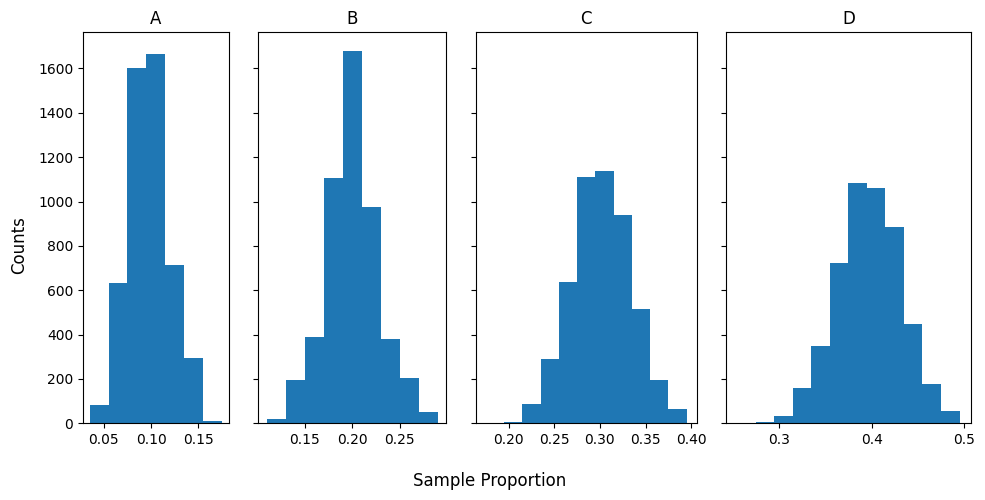

In [6]:
def plot_df_hist(df: pd.DataFrame, *, bar_width=0.02):
    maxs = df.max()
    mins = df.min()

    fig, axs = plt.subplots(
        1,
        len(df.columns),
        figsize=(10, 5),
        sharey=True,
        tight_layout=True,
        width_ratios=maxs - mins,
    )

    for i, col in enumerate(df.columns):
        axs[i].hist(df[col], bins=np.arange(mins[col], maxs[col], bar_width))
        axs[i].set_title(col)
    fig.supxlabel("Sample Proportion")
    fig.supylabel("Counts")
    return fig

props = sampling_dists(lambda: random_counts(rng, 200, [0.1, 0.2, 0.3, 0.4]), trials=5000)
fig = plot_df_hist(props)

In [7]:
def plot_df_hist_overlay(df: pd.DataFrame, *, bar_width=0.02):
    df_max = df.max().max()
    df_min = df.min().min()
    bins = np.arange(df_min, df_max, bar_width)

    for col in df.columns:
        plt.hist(df[col], bins=bins, alpha=0.5, label=col)
    plt.legend()
    plt.xlabel("Sample Proportion")
    plt.ylabel("Counts")

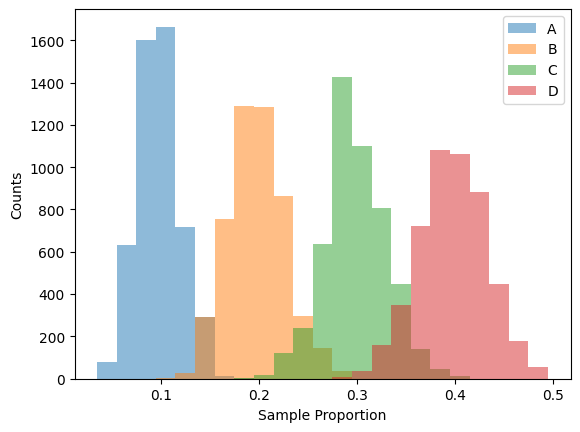

In [8]:
plot_df_hist_overlay(props)

In [9]:
def one_prop_z_int(props, n: int, conf: float = 0.95):
    norm = NormalDist()
    intervals = []
    for prop in props:
        me = abs(norm.inv_cdf((1 - conf) / 2)) * math.sqrt(prop * (1 - prop) / n)
        intervals.append((prop - me, prop + me))
    return intervals

one_prop_z_int(props.iloc[0], 200)

[(0.03849649292974339, 0.11150350707025661),
 (0.1267553137893342, 0.2332446862106658),
 (0.30308796628767737, 0.4369120337123226),
 (0.30790521961060663, 0.44209478038939337)]

In [10]:
def within_interval(props: pd.DataFrame, population_prop: list[float], n: int, conf: float = 0.95):
    result = np.empty(props.shape, bool)
    for i, row in props.iterrows():
        intervals = one_prop_z_int(list(row), n=n, conf=conf)
        for j, (lo, hi) in enumerate(intervals):
            result[i][j] = (lo < population_prop[j] < hi)

    return pd.DataFrame(result, columns=props.columns)

within_interval(props, [0.1, 0.2, 0.3, 0.4], 200)

,A,B,C,D
0,True,True,False,True
1,True,True,True,True
2,True,True,True,True
3,True,True,True,True
4,True,False,True,True
...,...,...,...,...
4995,True,True,True,True
4996,True,True,True,True
4997,True,True,True,False
4998,True,True,True,True


In [11]:
results = within_interval(props, [0.1, 0.2, 0.3, 0.4], 200)
results.sum(axis=1).value_counts()

,count
4,4001
3,801
2,189
1,9


In [12]:
# props.to_csv("ABCD_props.csv")

In [13]:
results.sum()

,0
A,4679
B,4707
C,4688
D,4720


In [14]:
5000*.95

4750.0

In [15]:
props.iloc[0]

,0
A,0.075
B,0.180
C,0.370
D,0.375
